# Artdaptive: adaptive painting

- The current implementation only considers a single color channel of the image. We could also consider a combination of them (e.g. an average).

- Also, the current implementation only works with squared images. 

- High-quality images make the runner to be slower.

- A smoothing could be used to improve the resulting plots.

<br>
&nbsp;
<br>
&nbsp;

In [169]:
import adaptive
adaptive.notebook_extension()

# Import modules that are used in multiple cells
import holoviews as hv
import numpy as np
from functools import partial
import random
import matplotlib.pylab as pl
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.integrate import simps

from adaptive.tests import test_average_learner1d as tests

from adaptive.learner.learner1D import (curvature_loss_function,
                                        uniform_loss,
                                        default_loss,
                                        triangle_loss)

%config InlineBackend.figure_formats=set(['svg'])

In [255]:
def load_image(image_name):
    import matplotlib.pyplot as plt
    import matplotlib.image as mpimg
    return mpimg.imread(image_name)

def image_function(xy,image=None,channel='r'):
    import numpy as np
    # Use only one color channel
    if channel=='r':
        img_red = img[:,:,0]
    elif channel=='g':
        img_red = img[:,:,1]
    elif channel=='b':
        img_red = img[:,:,2]

    # Round coordinates
    x, y = xy
    if np.abs(x)>1:
        x = 1*np.sign(x)
    if np.abs(y)>1:
        y = 1*np.sign(y)
    xx = int(round((x+1)*0.5*(len(img_red)-1)))
    yy = int(round((y+1)*0.5*(len(img_red[0])-1)))

    return img_red[-yy,xx]

def init_learner_image(image_name=None, channel='r'):
    from functools import partial
    assert isinstance('image_name', str), 'Image name not specified'
    
    img = load_image(image_name)
    assert len(img)==len(img[0]), 'Image not squared'
    fun = partial(image_function, image=img, channel=channel)
    
#    return adaptive.Learner2D(fun, bounds=[(0,len(img)), (0,len(img[0]))])
    return adaptive.Learner2D(fun, bounds=[(-1,1), (-1,1)])

In [256]:
def areas(ip):
    """Returns the area per triangle of the triangulation inside
    a `LinearNDInterpolator` instance.

    Is useful when defining custom loss functions.

    Parameters
    ----------
    ip : `scipy.interpolate.LinearNDInterpolator` instance

    Returns
    -------
    numpy array
        The area per triangle in ``ip.tri``.
    """
    p = ip.tri.points[ip.tri.vertices]
    q = p[:, :-1, :] - p[:, -1, None, :]
    areas = abs(q[:, 0, 0] * q[:, 1, 1] - q[:, 0, 1] * q[:, 1, 0]) / 2
    return areas

def plot_learner2D(learner, n=None, tri_alpha=0, cmap='viridis'):
    """Plot the Learner2D's current state.

    This plot function interpolates the data on a regular grid.
    The gridspacing is evaluated by checking the size of the smallest
    triangle.

    Parameters
    ----------
    n : int
        Number of points in x and y. If None (default) this number is
        evaluated by looking at the size of the smallest triangle.
    tri_alpha : float
        The opacity ``(0 <= tri_alpha <= 1)`` of the triangles overlayed
        on top of the image. By default the triangulation is not visible.
    cmap : str
        Colormap

    Returns
    -------
    plot : `holoviews.core.Overlay` or `holoviews.core.HoloMap`
        A `holoviews.core.Overlay` of
        ``holoviews.Image * holoviews.EdgePaths``. If the
        `learner.function` returns a vector output, a
        `holoviews.core.HoloMap` of the
        `holoviews.core.Overlay`\s wil be returned.

    Notes
    -----
    The plot object that is returned if ``learner.function`` returns a
    vector *cannot* be used with the live_plotting functionality.
    """
    import itertools
    from collections import OrderedDict
    from copy import copy
    from math import sqrt

    import numpy as np
    from scipy import interpolate

    from adaptive.learner.base_learner import BaseLearner
    from adaptive.notebook_integration import ensure_holoviews
    from adaptive.utils import cache_latest
    hv = ensure_holoviews()
    x, y = learner.bounds
    lbrt = x[0], y[0], x[1], y[1]

    if len(learner.data) >= 4:
        ip = learner.ip()

        if n is None:
            # Calculate how many grid points are needed.
            # factor from A=√3/4 * a² (equilateral triangle)
            n = int(0.658 / sqrt(areas(ip).min()))
            n = max(n, 10)

        # The bounds of the linspace should be (-0.5, 0.5) but because of
        # numerical precision problems it could (for example) be
        # (-0.5000000000000001, 0.49999999999999983), then any point at exact
        # boundary would be outside of the domain. See #181.
        eps = 1e-13
        x = y = np.linspace(-0.5 + eps, 0.5 - eps, n)
        z = ip(x[:, None], y[None, :] * learner.aspect_ratio).squeeze()

        if learner.vdim > 1:
            ims = {
                i: hv.Image(np.rot90(z[:, :, i]), bounds=lbrt)
                for i in range(z.shape[-1])
            }
            im = hv.HoloMap(ims)
        else:
            im = hv.Image(np.rot90(z), bounds=lbrt)

        if tri_alpha:
            points = learner._unscale(ip.tri.points[ip.tri.vertices])
            points = np.pad(
                points[:, [0, 1, 2, 0], :],
                pad_width=((0, 0), (0, 1), (0, 0)),
                mode="constant",
                constant_values=np.nan,
            ).reshape(-1, 2)
            tris = hv.EdgePaths([points])
        else:
            tris = hv.EdgePaths([])
    else:
        im = hv.Image([], bounds=lbrt)
        tris = hv.EdgePaths([])

    im_opts = dict(cmap=cmap)
    tri_opts = dict(line_width=0.5, alpha=tri_alpha)
    no_hover = dict(plot=dict(inspection_policy=None, tools=[]))

    return im.opts(style=im_opts) * tris.opts(style=tri_opts, **no_hover)

<br>
&nbsp;
<br>
&nbsp;

# Load image and initialize learner

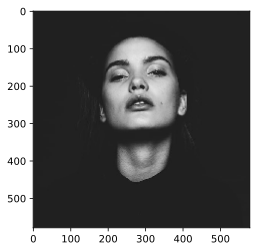

In [265]:
image_name = 'images/lorenzo-hamers.jpg'

image_name = 'images/jonatas-tinoco.jpg'

image_name = 'images/quantum-tinkerer.jpg'

image_name = 'images/peter-sjo.jpg'

learner = init_learner_image(image_name,channel='r')
img = loadimage(image_name)
plt.imshow(img)

<br>
&nbsp;
<br>
&nbsp;

# Run learner

In [266]:

runner = adaptive.Runner(learner, goal=lambda l: len(l.data) > 1000)

runner.live_info()

def plot(learner):
    plot = learner.plot(tri_alpha=0.2)
    return (plot.Image + plot.EdgePaths.I + plot).cols(2)

runner.live_plot(plotter=plot, update_interval=0.1)

Button(description='cancel live-plot', layout=Layout(width='150px'), style=ButtonStyle())

:DynamicMap   []
   :Layout
      .Overlay.I   :Overlay
         .I :Image   [x,y]   (z)
      .EdgePaths.I :EdgePaths   [x,y]
      .Overlay.II  :Overlay
         .Image.I     :Image   [x,y]   (z)
         .EdgePaths.I :EdgePaths   [x,y]

<br>
&nbsp;
<br>
&nbsp;

# Some examples

In [209]:
plot_learner2D(learner,tri_alpha=0.5,cmap='inferno')

:Overlay
   .Image.I     :Image   [x,y]   (z)
   .EdgePaths.I :EdgePaths   [x,y]

In [227]:
plot_learner2D(learner,tri_alpha=0.5,cmap='viridis')

:Overlay
   .Image.I     :Image   [x,y]   (z)
   .EdgePaths.I :EdgePaths   [x,y]

In [236]:
plot_learner2D(learner,tri_alpha=0,cmap='pink')

:Overlay
   .Image.I     :Image   [x,y]   (z)
   .EdgePaths.I :EdgePaths   [x,y]

In [248]:
plot_learner2D(learner,tri_alpha=0.3,cmap='blues')

:Overlay
   .Image.I     :Image   [x,y]   (z)
   .EdgePaths.I :EdgePaths   [x,y]